In [1]:
'''
Zé Fonseca

25/01/16

Compare contours of different datasets.  
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, splrep, splev, bisplrep, bisplev
from copy import deepcopy

%matplotlib inline

In [2]:
#cosmological functions
#general functions
def H(z,OM,H0,w):
    if w==-1:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM))
    else:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))

c=2.99792e5

def dL(z,OM,H0,w):
    return (1+z)*quad(lambda x:c/H(x,OM,H0,w),0,z)[0]

def mu(z,OM,H0,w):
    return 5*sp.log10(dL(z,OM,H0,w))+25

def dmudz_milne(z):
    return 10/np.log(10)*(1+z)/z/(z+2)

#class fake data with all the cases.

class fkd:
    def __init__(self,name,N=1000,z_min=0.015,z_max=1.0,OM=0.31,H0=67.74,w=-1,sig_mu=0.2):
        #parameters used
        self.N=N
        self.z_min=z_min
        self.z_max=z_max
        self.OM=OM
        self.H0=H0
        self.w=w
        self.dataset=name


        #get redshifts
        z=np.random.rand(N)*(z_max-z_min)+z_min
        z.sort()
        self.z=z
        
        #get magnitudes
        mu_t=np.array([mu(zi,OM,H0,w) for zi in z])
        mu_o=mu_t+np.random.randn(N)*sig_mu
        self.mu_t=mu_t
        self.mu_o=mu_o
        self.sig_mu=sig_mu
        
        self.case21=case21()
        self.case22=case22()
        self.case3=case3()
         
    def bias_sets_case21(self,error_z21=0.04):
        z_b21=np.zeros(len(self.z))
        for i in range(len(self.z)):
            z_b21[i]=self.z[i]+np.random.randn()*error_z21*(1+self.z[i])
            while z_b21[i]<=0:
                z_b21[i]=self.z[i]+np.random.randn()*error_z21*(1+self.z[i])
        
        
        self.case21.z=z_b21
        self.case21.mu_o=self.mu_o
        self.case21.sig_mu=self.sig_mu
        #mu error will be changed in MCMC
        self.case21.err_z=error_z21
        self.case21.cor=np.ones(self.N)
        
        self.case21.sig_milne2=self.sig_mu**2+(dmudz_milne(z_b21)*error_z21*(1+z_b21))**2
        
        self.case21.dataset=self.dataset+'_case21'
                
    def bias_sets_case22(self,error_z22=0.04):
        #case is the same as case 2.1 but with the original z<0.1 unchanged
        z_b22=deepcopy(self.case21.z)
        index=np.argwhere(self.z<=0.1)
        z_b22[index]=self.z[index]
                    
        self.case22.z=z_b22
        self.case22.mu_o=self.mu_o
        self.case22.err_z=error_z22
        self.case22.sig_mu=self.sig_mu
        index2=np.argwhere(z_b22<0.1)
        self.case22.cor=np.ones(self.N)
        self.case22.cor[index2]=0
        
        self.case22.sig_milne2=self.sig_mu**2+(dmudz_milne(z_b22)*error_z22*(1+z_b22)*self.case22.cor)**2
        
        self.case22.dataset=self.dataset+'_case22'
    
    def bias_sets_case3(self,dz_3=0.1,pgamma=0.91):
        
        z_b3=np.zeros(len(self.z))
        #second possible galaxy
        z_b3_2=np.zeros(len(self.z))
        for i in range(len(self.z)):
            if self.z[i]<=0.1:
                z_b3[i]=self.z[i]
                z_b3_2[i]=self.z[i]
            else:
                pvalue=np.random.rand()
                if pvalue>0.09:
                    z_b3[i]=self.z[i]
                    z_b3_2[i]=self.z[i]+np.random.randn()*dz_3
                    while z_b3_2[i]<=0:
                        z_b3_2[i]=self.z[i]+np.random.randn()*dz_3
                else:
                    z_b3[i]=self.z[i]+np.random.randn()*dz_3
                    z_b3_2[i]=self.z[i]
                    while z_b3[i]<=0:
                        z_b3[i]=self.z[i]+np.random.randn()*dz_3
                    
        
        self.case3.z=z_b3
        self.case3.z2=z_b3_2
        self.case3.mu_o=self.mu_o
        self.case3.dz=dz_3
        self.case3.sig_mu=self.sig_mu
        self.case3.pgamma=pgamma
        self.case3.dataset=self.dataset+'_case3'
        
    def get_case_data(self,filename,case,sig_mu=0.2,err_z=0.04,pgamma=0.91):
        
        dados=np.loadtxt(filename)
        
        if case==1:
            self.z=dados[:,0]
            self.mu_o=dados[:,1]
            self.sig_mu=sig_mu
            mu_t=np.array([mu(zi,0.31,67.74,-1) for zi in self.z]) 
            self.mu_t=mu_t
            
        if case==21:
            self.case21.z=dados[:,0]
            self.case21.mu_o=dados[:,1]
            self.case21.err_z=err_z
            self.case21.sig_mu=sig_mu
            self.case21.cor=np.ones(len(dados[:,0]))
            self.case21.sig_milne2=sig_mu**2+(dmudz_milne(dados[:,0])*err_z*(1+dados[:,0]))**2
            
            self.case21.dataset=self.dataset+'_case21'
            
        if case==22:
            self.case22.z=dados[:,0]
            self.case22.mu_o=dados[:,1]
            self.case22.err_z=err_z
            self.case22.sig_mu=sig_mu
            
            index2=np.argwhere(dados[:,0]<0.1)
            self.case22.cor=np.ones(len(dados[:,0]))
            self.case22.cor[index2]=0
            
            self.case22.sig_milne2=sig_mu**2+(dmudz_milne(dados[:,0])*err_z*(1+dados[:,0])*self.case22.cor)**2
            
            self.case22.dataset=self.dataset+'_case22'
            
        if case==3:
            self.case3.z=dados[:,0]
            self.case3.z2=dados[:,1]
            self.case3.mu_o=dados[:,2]
            self.case3.sig_mu=sig_mu
            self.case3.pgamma=pgamma
            self.case3.dataset=self.dataset+'_case3'
            
class case21(object):
    pass
    
class case22(object):
    pass
    
class case3(object):
    pass 

def get_case_chain(data,filename,subcase=False):
    dados=np.loadtxt(filename)
    
    if subcase=='b':
        data.milne_chain_o_m=deepcopy(dados[:,0])
        data.milne_chain_w=deepcopy(dados[:,1])
        data.milne_chain_H0=deepcopy(dados[:,2])
        data.milne_log_like=deepcopy(dados[:,3])
    elif subcase=='c':
        data.zn_chain_o_m=dados[:,0]
        data.zn_chain_w=dados[:,1]
        data.zn_chain_H0=dados[:,2]
        data.zn_log_like=dados[:,3]
    elif subcase=='unb3':
        data.unb3_chain_o_m=dados[:,0]
        data.unb3_chain_w=dados[:,1]
        data.unb3_chain_H0=dados[:,2]
        data.unb3_log_like=dados[:,3]
    else:
        data.chain_o_m=dados[:,0]
        data.chain_w=dados[:,1]
        data.chain_H0=dados[:,2]
        data.log_like=dados[:,3]
            
            
       

In [4]:
fds=['fd1','fd2','fd3','fd4','fd5','fd6']
datas={}
for i in range(len(fds)):
    datas[fds[i]]=fkd(fds[i])

In [6]:
#load original data
z_root = 'zf_chains_data/data_%s_case%s_zf.txt'
cases=[1,21,21,3]
for i in range(len(fds)):
    for j in range(len(cases)):
        datas[fds[i]].get_case_data(z_root %(fds[i],str(cases[j])),cases[j])        

In [7]:
mcmc_root = 'zf_chains_data/mcmc_%s%s_zf.txt'
types=['','_b','_c']
types2=['','b','c']

for i in range(len(fds)):
    get_case_chain(datas[fds[i]],mcmc_root %(fds[i],''))
    get_case_chain(datas[fds[i]].case3,mcmc_root %(fds[i],'_case3'))
    get_case_chain(datas[fds[i]].case3,mcmc_root %(fds[i],'_case3'),'unb3')
    for j in range(len(types)):
        get_case_chain(datas[fds[i]].case21,mcmc_root %(fds[i],'_case21'+types[j]),types2[j])
        get_case_chain(datas[fds[i]].case22,mcmc_root %(fds[i],'_case22'+types[j]),types2[j])


In [33]:
def plot_contour_hist(data,axarr,cor,z_noise=False,milne=False,z_2gal=False,burn_tail=500,thining=1,nb=20):    
    bins_om=[round(x*0.025,3) for x in range(0,40)]
    bins_w=[round(x*0.05-6,3) for x in range(0,140)]
    bins_H=[x*0.25+50 for x in range(0,200)]
    
    if z_noise==True:
        om=data.zn_chain_o_m[burn_tail::thining]
        w=data.zn_chain_w[burn_tail::thining]
        H0=data.zn_chain_H0[burn_tail::thining]
    elif milne==True:
        om=data.milne_chain_o_m[burn_tail::thining]
        w=data.milne_chain_w[burn_tail::thining]
        H0=data.milne_chain_H0[burn_tail::thining]
    elif z_2gal==True:
        om=data.unb3_chain_o_m[burn_tail::thining]
        w=data.unb3_chain_w[burn_tail::thining]
        H0=data.unb3_chain_H0[burn_tail::thining]
    else:
        om=data.chain_o_m[burn_tail::thining]
        w=data.chain_w[burn_tail::thining]
        H0=data.chain_H0[burn_tail::thining]
        
    Hist_mcmc, omedges,wedges = np.histogram2d(om,w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Neff=len(om)
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Neff)
    
    axarr[0,0].hist(om,color=cor,bins=bins_om,alpha=0.2)
    axarr[1,0].contour(om_c,w_c, Hist_mcmc.T,levels=[N95,N68,Nmax], colors=cor)
    axarr[0,1].hist(H0,bins=bins_H,color=cor,alpha=0.2)
    axarr[1,1].hist(w,bins=bins_w,color=cor,alpha=0.2,orientation=u'horizontal')
    
def set_labels(axarr):
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    axarr[0,1].set_xlabel(r'$H_0$')

def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95

def set_len(axarr,om_min,om_max,w_min,w_max,h0_min,h0_max):
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,1].set_xlim([h0_min,h0_max])
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,1].set_ylim([w_min,w_max])

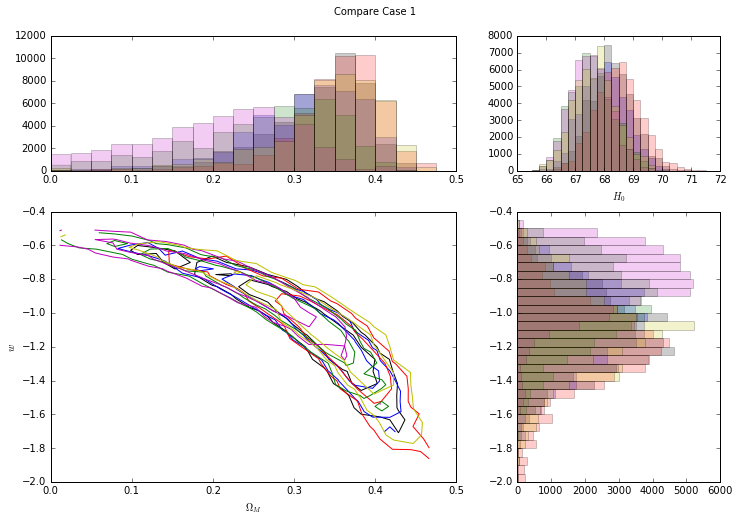

In [14]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
cor=['k','b','r','g','m','y']
f.text(0.5, 0.95, 'Compare Case 1',horizontalalignment='center',verticalalignment='top')
for i in range(len(fds)):
    plot_contour_hist(datas[fds[i]],axarr,cor[i])

set_labels(axarr)
set_len(axarr,0,0.5,-2,-0.4,65,72)
plt.show()
    

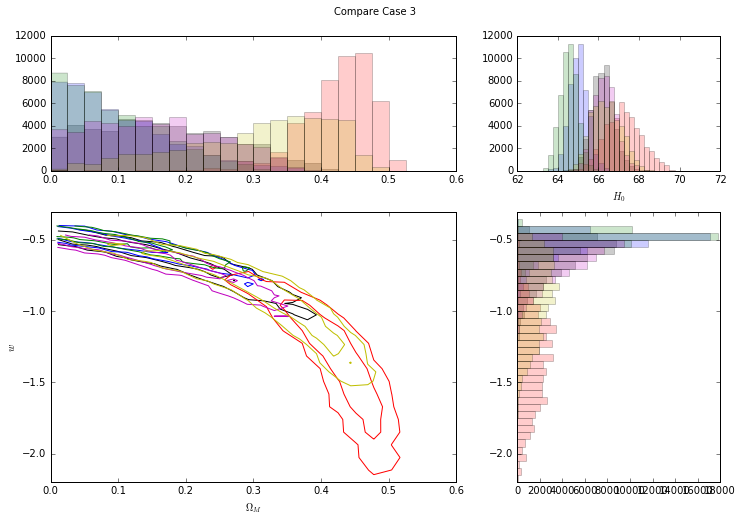

In [18]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
cor=['k','b','r','g','m','y']
f.text(0.5, 0.95, 'Compare Case 3',horizontalalignment='center',verticalalignment='top')
for i in range(len(fds)):
    plot_contour_hist(datas[fds[i]].case3,axarr,cor[i])

set_labels(axarr)
set_len(axarr,0,0.6,-2.2,-0.3,62,72)
plt.show()
    

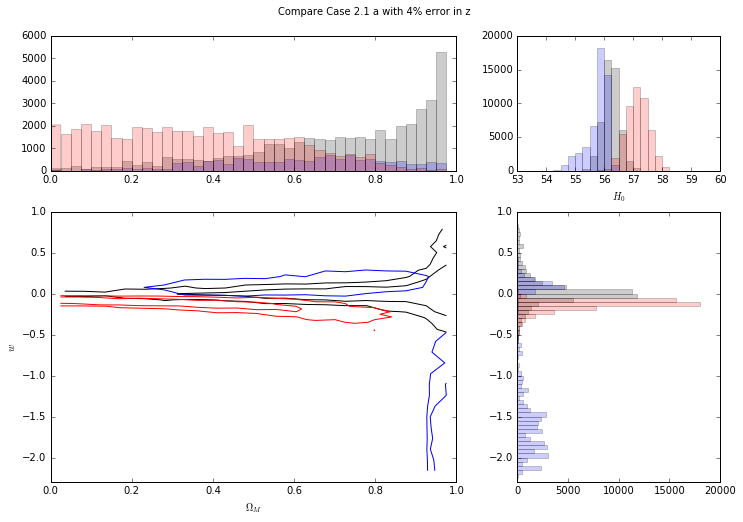

In [26]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
sig4p=[0,2,3]
f.text(0.5, 0.95, 'Compare Case 2.1 a with 4% error in z',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig4p)):
    plot_contour_hist(datas[fds[sig4p[i]]].case21,axarr,cor[i])

set_labels(axarr)
set_len(axarr,0,1,-2.3,1,53,60)
plt.show()

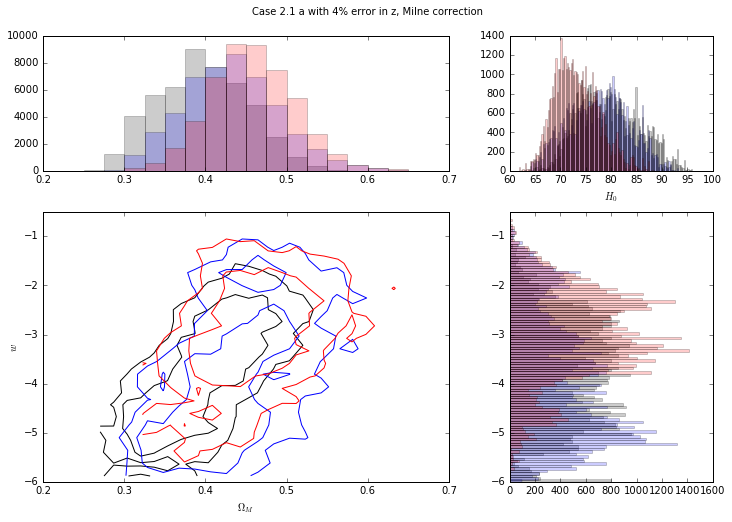

In [35]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
sig4p=[0,2,3]
f.text(0.5, 0.95, 'Case 2.1 a with 4% error in z, Milne correction',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig4p)):
    plot_contour_hist(datas[fds[sig4p[i]]].case21,axarr,cor[i],milne=True)

set_labels(axarr)
set_len(axarr,0.2,0.7,-6,-0.5,60,100)
plt.show()

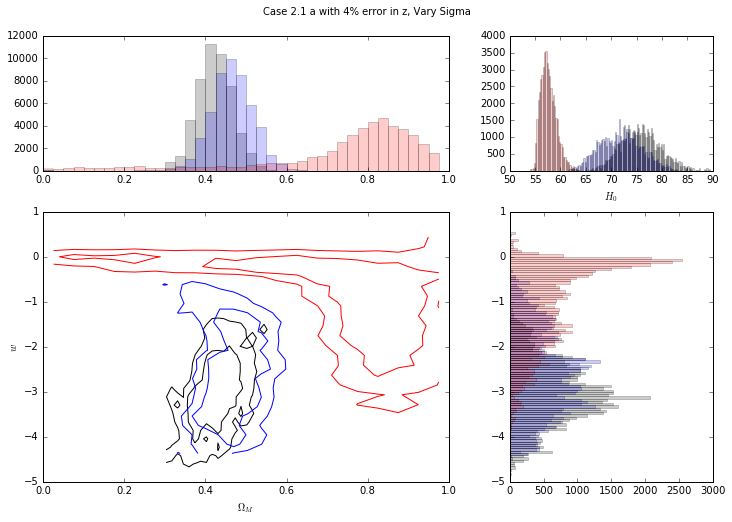

In [37]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
sig4p=[0,2,3]
f.text(0.5, 0.95, 'Case 2.1 a with 4% error in z, Vary Sigma',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig4p)):
    plot_contour_hist(datas[fds[sig4p[i]]].case21,axarr,cor[i],z_noise=True)

set_labels(axarr)
set_len(axarr,0,1,-5,1,50,90)
plt.show()

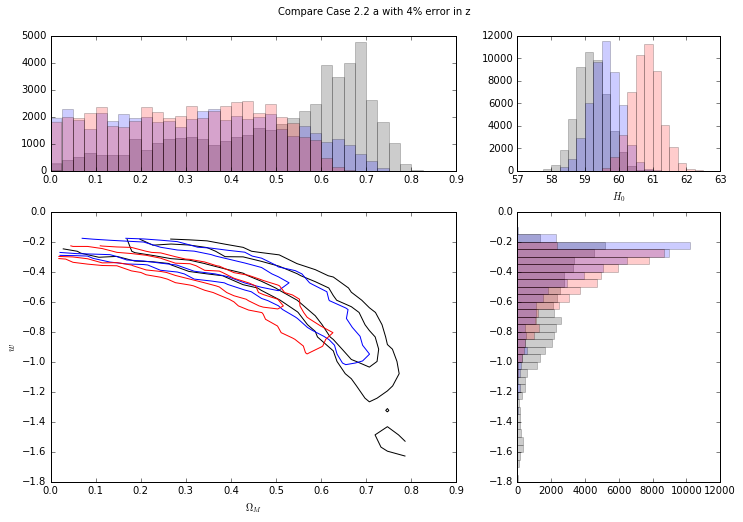

In [39]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

f.text(0.5, 0.95, 'Compare Case 2.2 a with 4% error in z',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig4p)):
    plot_contour_hist(datas[fds[sig4p[i]]].case22,axarr,cor[i])

set_labels(axarr)
set_len(axarr,0,0.9,-1.8,0,57,63)
plt.show()

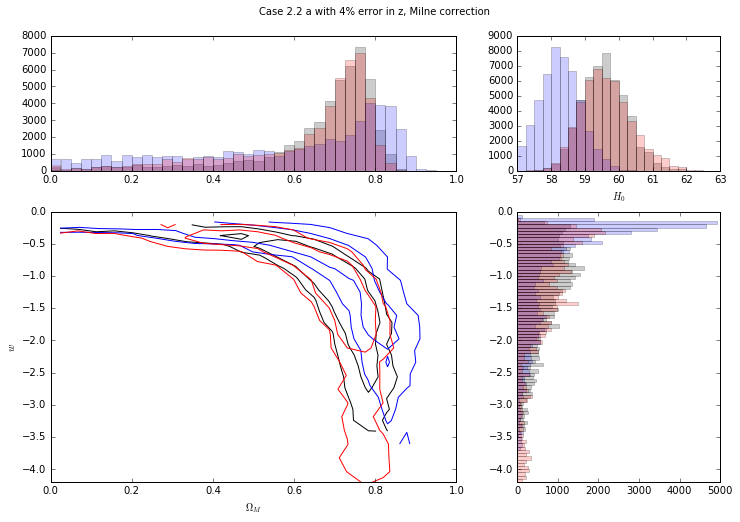

In [42]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

f.text(0.5, 0.95, 'Case 2.2 a with 4% error in z, Milne correction',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig4p)):
    plot_contour_hist(datas[fds[sig4p[i]]].case22,axarr,cor[i],milne=True)

set_labels(axarr)
set_len(axarr,0,1,-4.2,0,57,63)
plt.show()

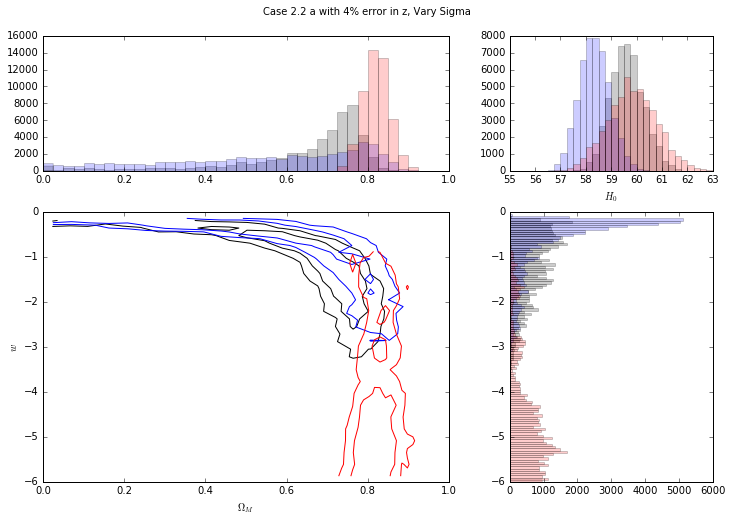

In [45]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

f.text(0.5, 0.95, 'Case 2.2 a with 4% error in z, Vary Sigma',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig4p)):
    plot_contour_hist(datas[fds[sig4p[i]]].case22,axarr,cor[i],z_noise=True)

set_labels(axarr)
set_len(axarr,0,1,-6,0,55,63)
plt.show()

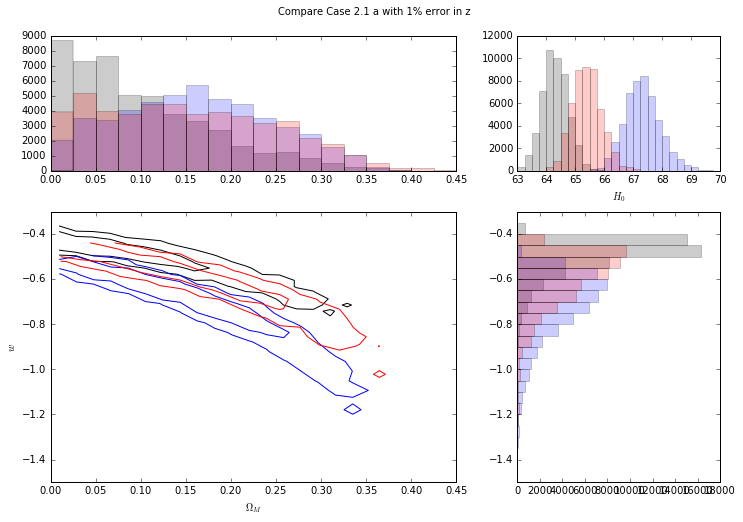

In [48]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
sig1p=[1,4,5]
f.text(0.5, 0.95, 'Compare Case 2.1 a with 1% error in z',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig1p)):
    plot_contour_hist(datas[fds[sig1p[i]]].case21,axarr,cor[i])

set_labels(axarr)
set_len(axarr,0,0.45,-1.5,-0.3,63,70)
plt.show()

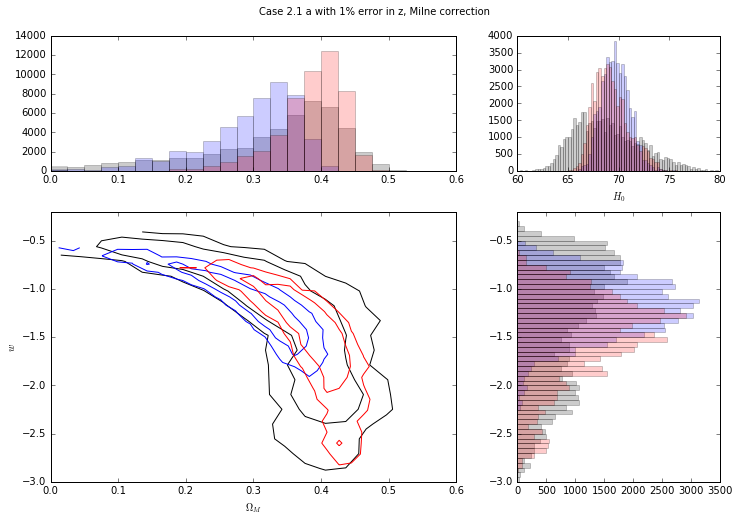

In [51]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

f.text(0.5, 0.95, 'Case 2.1 a with 1% error in z, Milne correction',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig4p)):
    plot_contour_hist(datas[fds[sig1p[i]]].case21,axarr,cor[i],milne=True)

set_labels(axarr)
set_len(axarr,0,0.6,-3,-0.2,60,80)

plt.show()

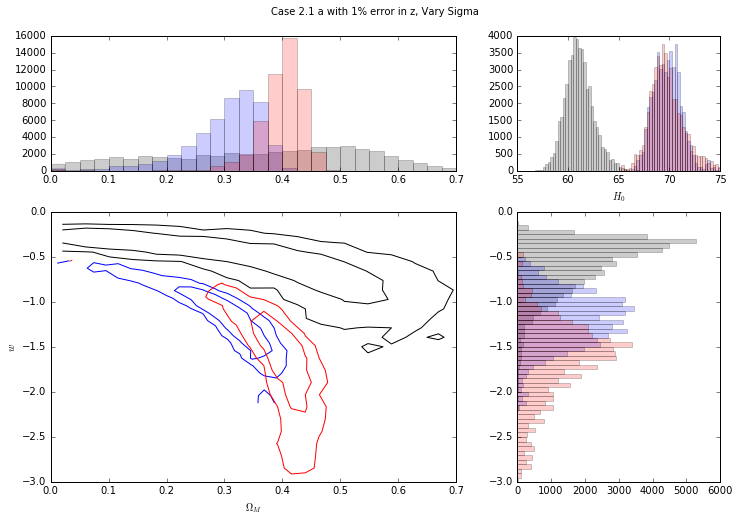

In [53]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

f.text(0.5, 0.95, 'Case 2.1 a with 1% error in z, Vary Sigma',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig1p)):
    plot_contour_hist(datas[fds[sig1p[i]]].case21,axarr,cor[i],z_noise=True)

set_labels(axarr)
set_len(axarr,0,0.7,-3,0,55,75)
plt.show()

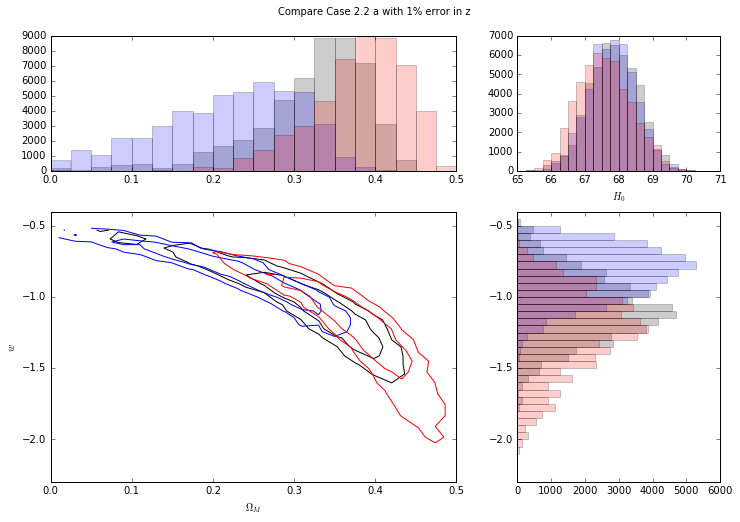

In [57]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
sig1p=[1,4,5]
f.text(0.5, 0.95, 'Compare Case 2.2 a with 1% error in z',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig1p)):
    plot_contour_hist(datas[fds[sig1p[i]]].case22,axarr,cor[i])

set_labels(axarr)
set_len(axarr,0,0.5,-2.3,-0.4,65,71)
plt.show()

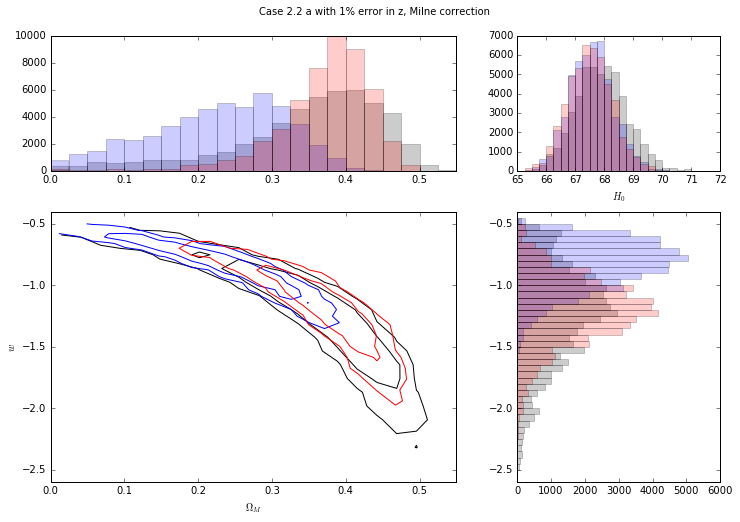

In [62]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

f.text(0.5, 0.95, 'Case 2.2 a with 1% error in z, Milne correction',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig4p)):
    plot_contour_hist(datas[fds[sig1p[i]]].case22,axarr,cor[i],milne=True)

set_labels(axarr)
set_len(axarr,0,0.55,-2.6,-0.4,65,72)

plt.show()

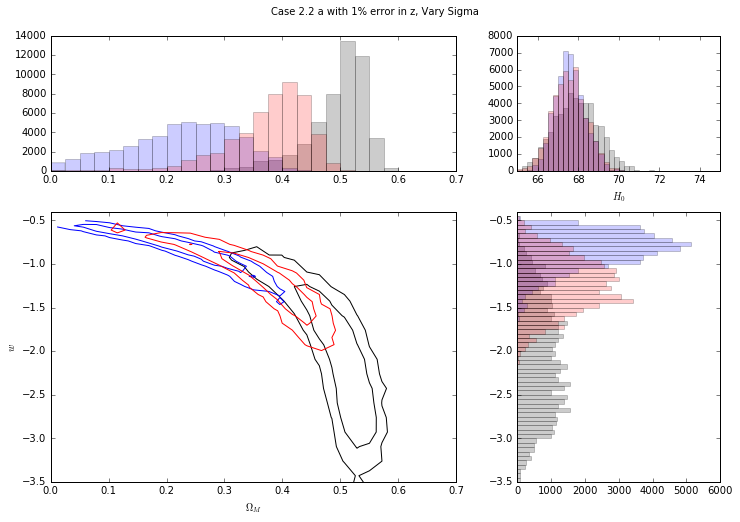

In [63]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

f.text(0.5, 0.95, 'Case 2.2 a with 1% error in z, Vary Sigma',horizontalalignment='center',verticalalignment='top')
for i in range(len(sig1p)):
    plot_contour_hist(datas[fds[sig1p[i]]].case22,axarr,cor[i],z_noise=True)

set_labels(axarr)
set_len(axarr,0,0.7,-3.5,-0.4,65,75)
plt.show()